In [2]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import string
import re

from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.collocations import *

from nltk import word_tokenize, FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

np.random.seed(0)

In [2]:
corpus = pd.read_csv('corpus_06122021.csv')
corpus.shape

(121620, 2)

In [3]:
corpus.head()

,target,body
0,4.0,I worked as a contractor for them for about tw...
1,1.0,"Worst place I've ever worked, hands down."
2,3.0,The compnay has good benefits and even a small...
3,1.0,Company has no life and work balance. Everyda...
4,5.0,"I no long work for Ball, the drive to work was..."


## Manual cleanup

In [4]:
review_test = corpus.iloc[1354].body
review_test

"Do yourself a favor: if you work here, do not go into pick at all if you don't like moving around constantly. Also, if you end up working here, actually work? A lot of people come in and don't do their jobs which makes everyone else's job harder. They only write up the bottom 5% of performers and it takes 3 write ups to get fired. Managers change every 6 months. So, if you hate your manager or if you like them or you never see them? Doesn't matter cuz you'll get another soon."

In [5]:
rating_test = corpus.iloc[1354].target
rating_test

3.0

In [6]:
corpus.target.value_counts()

5.0    37147
4.0    33875
3.0    26850
1.0    12285
2.0    11463
Name: target, dtype: int64

In [7]:
example_tokens=review_test.split(' ')
manual_cleanup_example = [word.lower() for word in example_tokens]
print(manual_cleanup_example)

['do', 'yourself', 'a', 'favor:', 'if', 'you', 'work', 'here,', 'do', 'not', 'go', 'into', 'pick', 'at', 'all', 'if', 'you', "don't", 'like', 'moving', 'around', 'constantly.', 'also,', 'if', 'you', 'end', 'up', 'working', 'here,', 'actually', 'work?', 'a', 'lot', 'of', 'people', 'come', 'in', 'and', "don't", 'do', 'their', 'jobs', 'which', 'makes', 'everyone', "else's", 'job', 'harder.', 'they', 'only', 'write', 'up', 'the', 'bottom', '5%', 'of', 'performers', 'and', 'it', 'takes', '3', 'write', 'ups', 'to', 'get', 'fired.', 'managers', 'change', 'every', '6', 'months.', 'so,', 'if', 'you', 'hate', 'your', 'manager', 'or', 'if', 'you', 'like', 'them', 'or', 'you', 'never', 'see', 'them?', "doesn't", 'matter', 'cuz', "you'll", 'get', 'another', 'soon.']


In [8]:
print(f"Our initial token set for our sample review is {len(manual_cleanup_example)} words long")

Our initial token set for our sample review is 94 words long


In [9]:
print(f"Our initial token set for our sample review has \
{len(set(example_tokens))} unique words")

Our initial token set for our sample review has 75 unique words


In [10]:
print(f"After removing capitals, our sample review has \
{len(set(manual_cleanup_example))} unique words")

After removing capitals, our sample review has 73 unique words


In [11]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [12]:
punct_custom=string.punctuation.replace('$','')
punct_custom

'!"#%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [13]:
manual_cleanup_example = [s.translate(str.maketrans('', '', punct_custom))\
                  for s in manual_cleanup_example]
print(manual_cleanup_example)

['do', 'yourself', 'a', 'favor', 'if', 'you', 'work', 'here', 'do', 'not', 'go', 'into', 'pick', 'at', 'all', 'if', 'you', 'dont', 'like', 'moving', 'around', 'constantly', 'also', 'if', 'you', 'end', 'up', 'working', 'here', 'actually', 'work', 'a', 'lot', 'of', 'people', 'come', 'in', 'and', 'dont', 'do', 'their', 'jobs', 'which', 'makes', 'everyone', 'elses', 'job', 'harder', 'they', 'only', 'write', 'up', 'the', 'bottom', '5', 'of', 'performers', 'and', 'it', 'takes', '3', 'write', 'ups', 'to', 'get', 'fired', 'managers', 'change', 'every', '6', 'months', 'so', 'if', 'you', 'hate', 'your', 'manager', 'or', 'if', 'you', 'like', 'them', 'or', 'you', 'never', 'see', 'them', 'doesnt', 'matter', 'cuz', 'youll', 'get', 'another', 'soon']


In [14]:
print(f"After removing punctuation, our sample review has \
{len(set(manual_cleanup_example))} unique words")

After removing punctuation, our sample review has 71 unique words


In [15]:
stops = [token for token in manual_cleanup_example if token in stopwords.words('english')]
print(stops)

['do', 'yourself', 'a', 'if', 'you', 'here', 'do', 'not', 'into', 'at', 'all', 'if', 'you', 'if', 'you', 'up', 'here', 'a', 'of', 'in', 'and', 'do', 'their', 'which', 'they', 'only', 'up', 'the', 'of', 'and', 'it', 'to', 'so', 'if', 'you', 'your', 'or', 'if', 'you', 'them', 'or', 'you', 'them']


In [16]:
print(f'There are {len(stops)} stopwords in the sample review')

There are 43 stopwords in the sample review


In [17]:
print(f'That is {len(stops)/len(manual_cleanup_example): 0.2%} of our text')

That is  45.74% of our text


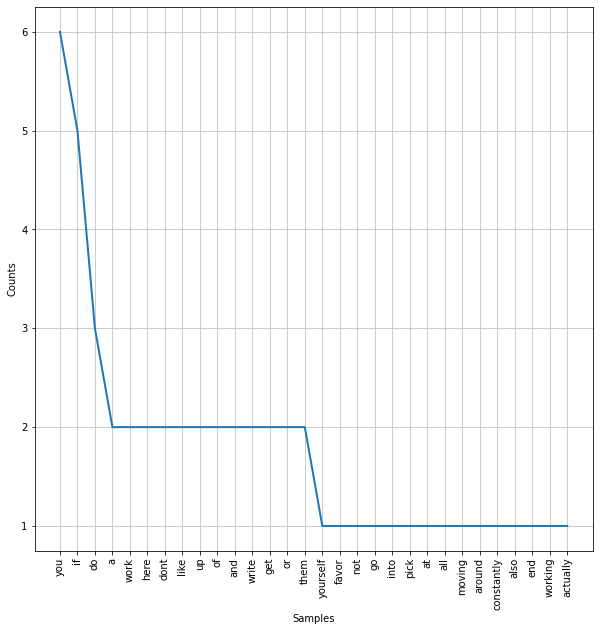

In [18]:
fdist = FreqDist(manual_cleanup_example)
plt.figure(figsize=(10, 10))
fdist.plot(30);

In [19]:
manual_cleanup_example = [token for token in manual_cleanup_example if\
                  token not in stopwords.words('english')]

In [20]:
print(manual_cleanup_example)

['favor', 'work', 'go', 'pick', 'dont', 'like', 'moving', 'around', 'constantly', 'also', 'end', 'working', 'actually', 'work', 'lot', 'people', 'come', 'dont', 'jobs', 'makes', 'everyone', 'elses', 'job', 'harder', 'write', 'bottom', '5', 'performers', 'takes', '3', 'write', 'ups', 'get', 'fired', 'managers', 'change', 'every', '6', 'months', 'hate', 'manager', 'like', 'never', 'see', 'doesnt', 'matter', 'cuz', 'youll', 'get', 'another', 'soon']


In [21]:
print(f"After removing stopwords, our sample review has \
{len(set(manual_cleanup_example))} unique words")

After removing stopwords, our sample review has 46 unique words


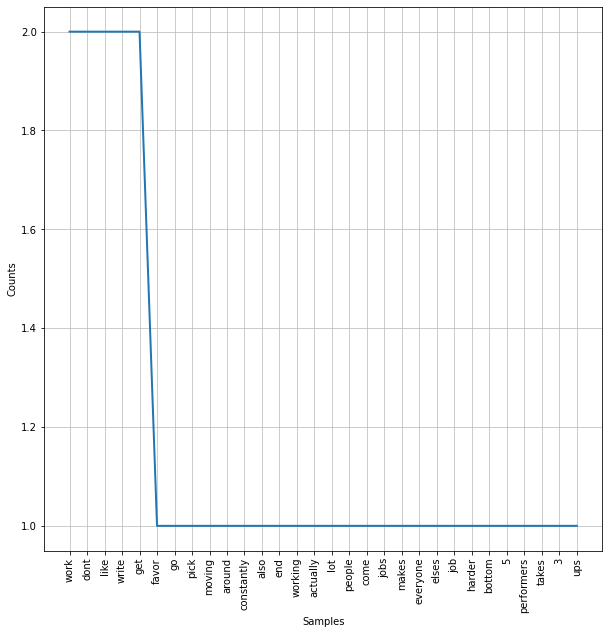

In [22]:
fdist = FreqDist(manual_cleanup_example)
plt.figure(figsize=(10, 10))
fdist.plot(30);

In [23]:
manual_cleanup_example = [s.translate(str.maketrans('', '', '0123456789')) \
                  for s in manual_cleanup_example]

In [24]:
print(f"After removing numbers, our sample review has \
{len(set(manual_cleanup_example))} unique words")

After removing numbers, our sample review has 44 unique words


In [25]:
manual_cleanup_example = [s for s in manual_cleanup_example if s != '' ]

In [26]:
print(f"After removing empty strings, our sample review has \
{len(set(manual_cleanup_example))} unique words")

After removing empty strings, our sample review has 43 unique words


In [27]:
print(manual_cleanup_example)

['favor', 'work', 'go', 'pick', 'dont', 'like', 'moving', 'around', 'constantly', 'also', 'end', 'working', 'actually', 'work', 'lot', 'people', 'come', 'dont', 'jobs', 'makes', 'everyone', 'elses', 'job', 'harder', 'write', 'bottom', 'performers', 'takes', 'write', 'ups', 'get', 'fired', 'managers', 'change', 'every', 'months', 'hate', 'manager', 'like', 'never', 'see', 'doesnt', 'matter', 'cuz', 'youll', 'get', 'another', 'soon']


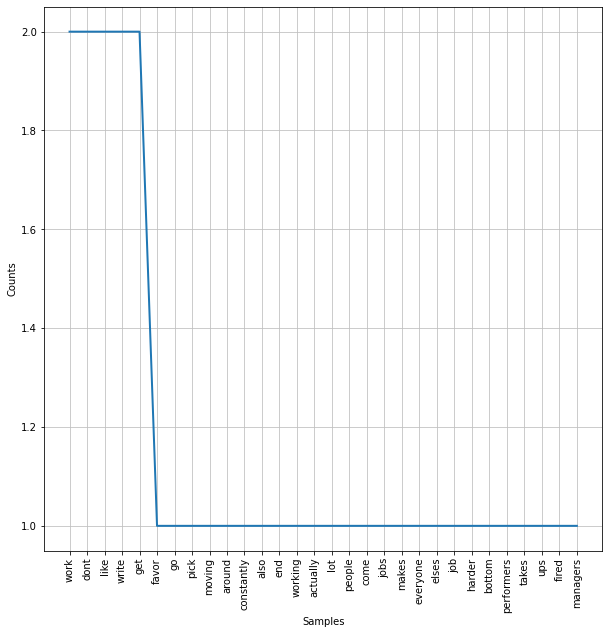

In [28]:
fdist = FreqDist(manual_cleanup_example)
plt.figure(figsize=(10, 10))
fdist.plot(30);

## Using Tokenizers

In [29]:
pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
tokenizer = RegexpTokenizer(pattern)
first_rev = tokenizer.tokenize(review_test)

In [30]:
first_rev = [token.lower() for token in first_rev]
first_rev = [token for token in first_rev if token not in stopwords.words('english')]

In [32]:
print(first_rev)

['favor', 'work', 'go', 'pick', 'like', 'moving', 'around', 'constantly', 'also', 'end', 'working', 'actually', 'work', 'lot', 'people', 'come', 'jobs', 'makes', 'everyone', "else's", 'job', 'harder', 'write', 'bottom', 'performers', 'takes', 'write', 'ups', 'get', 'fired', 'managers', 'change', 'every', 'months', 'hate', 'manager', 'like', 'never', 'see', 'matter', 'cuz', 'get', 'another', 'soon']


In [31]:
print(f"After using RegexpTokenizer, our sample review has \
{len(set(first_rev))} unique words")

After using RegexpTokenizer, our sample review has 40 unique words
